In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [24]:
# target top 5 sustance
substance_colors = {
    "Fluoranthene": "purple",
    "Copper": "red",
    "Indeno(1,2,3-cd)pyrene": "orange",
    "Benzo(a)pyrene": "green",
    "Cypermethrin": "blue",
}
target_substances = list(substance_colors.keys())

data_files = {
    2016: "Dataset_v4/d16_v4.csv",
    2017: "Dataset_v4/d17_v4.csv",
    2018: "Dataset_v4/d18_v4.csv",
    2019: "Dataset_v4/d19_v4.csv",
    2020: "Dataset_v4/d20_v4.csv",
    2021: "Dataset_v4/d21_v4.csv",
    2022: "Dataset_v4/d22_v4.csv",
    2023: "Dataset_v4/d23_v4.csv",
}

all_data = []

# load and process the data
for year, path in data_files.items():
    if not os.path.exists(path):
        continue
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()
    df["REGION"] = df["REGION"].str.strip()
    
    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["REGION"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna()
    ].copy()

    df["Year"] = year
    all_data.append(df)

# Merge the data
df_all = pd.concat(all_data, ignore_index=True)

### The quantity releasing of each substance in each Region

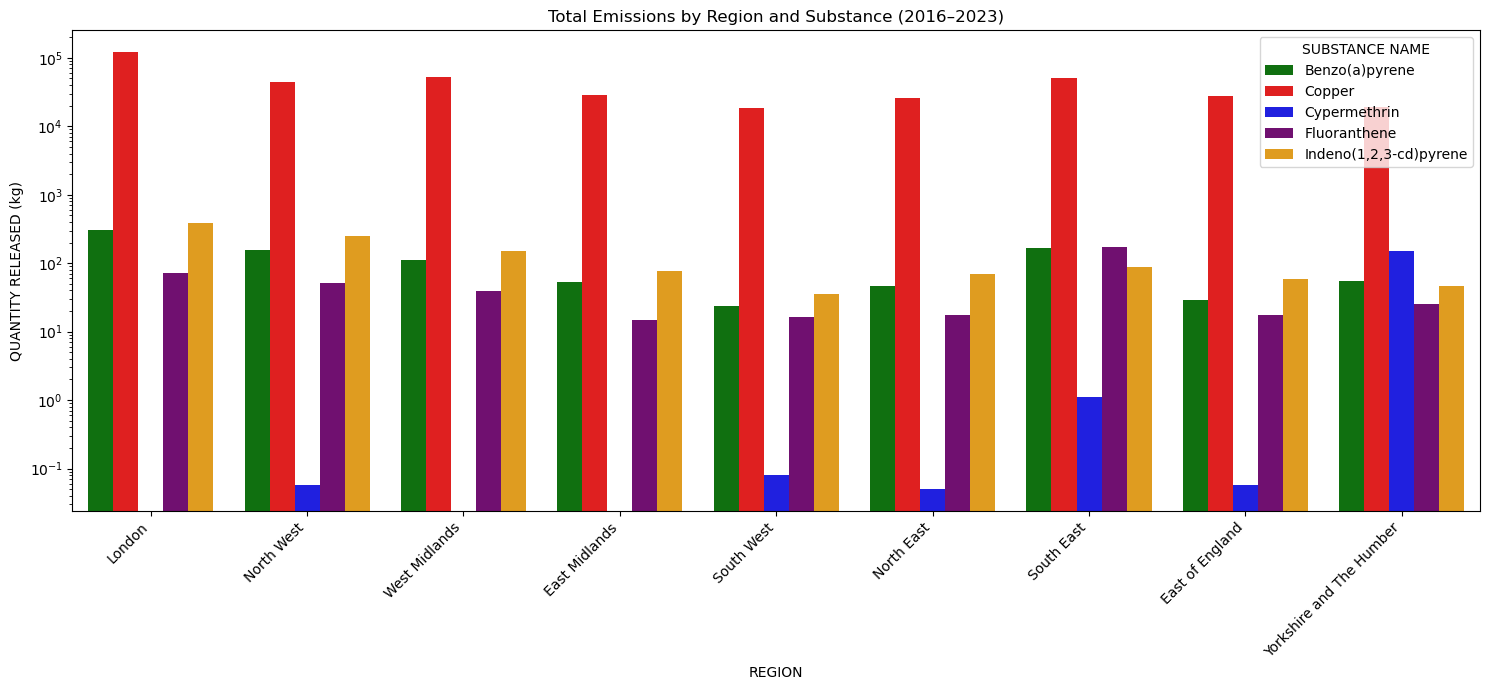

In [25]:
# Aggregate the total emissions by Region
region_totals = df.groupby("REGION")["QUANTITY RELEASED (kg)"].sum().sort_values(ascending=False)

# Obtain the sorted order of regions
sorted_regions = region_totals.index.tolist()

grouped_bar = (
    df_all.groupby(["REGION", "SUBSTANCE NAME"])["QUANTITY RELEASED (kg)"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(15, 7))
sns.barplot(
    data=grouped_bar,
    x="REGION",
    y="QUANTITY RELEASED (kg)",
    hue="SUBSTANCE NAME",
    order=sorted_regions,
    palette=substance_colors
)
plt.yscale("log")  # Using logarithmic coordinates
plt.xticks(rotation=45, ha="right")
plt.title("Total Emissions by Region and Substance (2016–2023)")
plt.tight_layout()
plt.savefig("RegionAnalysis/region_substance_grouped_bar.png", dpi=300)
plt.show()

### Filter the most contaminated regions （According to PNEC）

In [36]:
import pandas as pd

# PNEC value
pnec_values = {
    "Indeno(1,2,3-cd)pyrene": 0.00017,
    "Benzo(a)pyrene": 0.00017,  
    "Cypermethrin": 3e-05,
    "Fluoranthene": 0.000762,
    "Copper": 1.0,
}

csv_paths = [
    "Dataset_v4/d16_v4.csv",
    "Dataset_v4/d17_v4.csv",
    "Dataset_v4/d18_v4.csv",
    "Dataset_v4/d19_v4.csv",
    "Dataset_v4/d20_v4.csv",
    "Dataset_v4/d21_v4.csv",
    "Dataset_v4/d22_v4.csv",
    "Dataset_v4/d23_v4.csv",
]

dfs = []
for path in csv_paths:
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()
    df["Year"] = int(path.split("/d")[1].split("_")[0]) + 2000  
    dfs.append(df)

all_data = pd.concat(dfs, ignore_index=True)

# filter the data
target_substances = list(pnec_values.keys())
df_filtered = all_data[
    all_data["SUBSTANCE NAME"].isin(target_substances) &
    all_data["Latitude"].notna() &
    all_data["Longitude"].notna() &
    all_data["REPORTING THRESHOLD (kg)"].notna() &
    all_data["QUANTITY RELEASED (kg)"].notna() &
    all_data["REGION"].notna()
].copy()

df_filtered["PNEC"] = df_filtered["SUBSTANCE NAME"].map(pnec_values)
df_filtered["PNEC_SCORE"] = df_filtered["QUANTITY RELEASED (kg)"] / df_filtered["PNEC"]

# Aggregate the pollution intensity by Region
region_severity = df_filtered.groupby("REGION")["PNEC_SCORE"].sum().reset_index()
region_severity = region_severity.sort_values("PNEC_SCORE", ascending=False).reset_index(drop=True)
region_severity.rename(columns={"PNEC_SCORE": "Total PNEC-Normalized Emission"}, inplace=True)

print("\n Region Pollution Severity Ranking (Based on PNEC):")
print(region_severity.to_string(index=False))



 Region Pollution Severity Ranking (Based on PNEC):
                  REGION  Total PNEC-Normalized Emission
Yorkshire and The Humber                    5.591759e+06
                  London                    4.264943e+06
              North West                    2.503730e+06
              South East                    1.795308e+06
           West Midlands                    1.646293e+06
           East Midlands                    8.100235e+05
              North East                    7.263153e+05
         East of England                    5.719854e+05
              South West                    3.871634e+05
